Copyright (c) Meta Platforms, Inc. and affiliates.

Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

## Environment Set-up
If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [1]:
using_colab = True
if using_colab:
    import torch; assert torch.cuda.is_available()
    import torchvision;
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys;
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p ../checkpoints/

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-qntc9sud
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-qntc9sud
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

## Set-up + Fuction Definitions


In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)


def plot_iou_colormap_overlay(image, masks, max_area=2000):
    """
    Displays the original image next to a heatmap overlay showing predicted IoU
    of each mask, only including masks with area less than max_area (pixels).
    """
    overlay = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.float32)

    # Filter masks by area
    filtered_masks = [mask for mask in masks if mask['area'] < max_area]

    if not filtered_masks:
        print("No masks passed the area threshold.")
        return

    # Normalize IoU for color mapping
    ious = np.array([mask['predicted_iou'] for mask in filtered_masks])
    iou_min, iou_max = ious.min(), ious.max()
    norm_ious = (ious - iou_min) / (iou_max - iou_min + 1e-8)

    for mask, norm_iou in zip(filtered_masks, norm_ious):
        m = mask['segmentation']
        color = plt.cm.plasma(norm_iou)  # RGBA
        overlay[m] = color

    # Blend overlay with original image
    image_rgb = image / 255.0 if image.max() > 1 else image
    blended = (1 - overlay[..., 3:]) * image_rgb + overlay[..., :3] * overlay[..., 3:]

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(blended)
    axes[1].set_title(f"IoU-Colored Masks (area < {max_area})")
    axes[1].axis("off")

    sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=iou_min, vmax=iou_max))
    sm.set_array([])
    fig.colorbar(sm, ax=axes[1], orientation='vertical', fraction=0.05, pad=0.04, label='Predicted IoU')

    plt.tight_layout()
    plt.show()


def plot_stability_colormap_overlay(image, masks, max_area=2000):
    """
    Displays the original image next to a heatmap overlay showing stability score
    of each mask, only including masks with area less than max_area (pixels).
    """
    overlay = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.float32)

    # Filter masks by area
    filtered_masks = [mask for mask in masks if mask['area'] < max_area]

    if not filtered_masks:
        print("No masks passed the area threshold.")
        return

    # Normalize stability scores to [0, 1]
    scores = np.array([mask['stability_score'] for mask in filtered_masks])
    score_min, score_max = scores.min(), scores.max()
    norm_scores = (scores - score_min) / (score_max - score_min + 1e-8)

    for mask, norm_score in zip(filtered_masks, norm_scores):
        m = mask['segmentation']
        color = plt.cm.viridis(norm_score)  # Use viridis colormap for stability
        overlay[m] = color  # Assign RGBA color to masked region

    # Blend overlay with original image
    image_rgb = image / 255.0 if image.max() > 1 else image
    blended = (1 - overlay[..., 3:]) * image_rgb + overlay[..., :3] * overlay[..., 3:]

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(blended)
    axes[1].set_title(f"Stability-Colored Masks (area < {max_area})")
    axes[1].axis("off")

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=score_min, vmax=score_max))
    sm.set_array([])
    fig.colorbar(sm, ax=axes[1], orientation='vertical', fraction=0.05, pad=0.04, label='Stability Score')

    plt.tight_layout()
    plt.show()


from matplotlib.widgets import Slider, CheckButtons

def interactive_mask_filter(image, masks, max_area=2000):
    image_rgb = image / 255.0 if image.max() > 1 else image

    # Initial filter thresholds
    init_iou_thresh = 0.85
    init_stability_thresh = 0.85

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.subplots_adjust(left=0.25, bottom=0.3)

    img_display = ax.imshow(image_rgb)
    mask_overlay = ax.imshow(np.zeros_like(image_rgb), alpha=0.5)
    ax.axis('off')
    ax.set_title("Interactive Mask Filter")

    # --- Sliders ---
    ax_iou = plt.axes([0.25, 0.2, 0.65, 0.03])
    ax_stability = plt.axes([0.25, 0.15, 0.65, 0.03])

    s_iou = Slider(ax_iou, 'Min IoU', 0.8, 1.0, valinit=init_iou_thresh, valstep=0.01)
    s_stability = Slider(ax_stability, 'Min Stability', 0.8, 1.0, valinit=init_stability_thresh, valstep=0.01)

    # --- Checkbox ---
    ax_check = plt.axes([0.025, 0.7, 0.15, 0.15])
    check = CheckButtons(ax_check, ['Show Masks'], [True])

    def update(val=None):
        iou_thresh = s_iou.val
        stab_thresh = s_stability.val
        show_masks = check.get_status()[0]

        overlay = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.float32)

        if show_masks:
            filtered = [
                m for m in masks
                if m['area'] < max_area
                and m['predicted_iou'] >= iou_thresh
                and m['stability_score'] >= stab_thresh
            ]

            if filtered:
                ious = np.array([m['predicted_iou'] for m in filtered])
                norm_ious = (ious - 0.8) / (1.0 - 0.8 + 1e-8)
                for m, norm_iou in zip(filtered, norm_ious):
                    mask = m['segmentation']
                    color = plt.cm.plasma(norm_iou)
                    overlay[mask] = color

        blended = (1 - overlay[..., 3:]) * image_rgb + overlay[..., :3] * overlay[..., 3:]
        mask_overlay.set_data(blended)
        fig.canvas.draw_idle()

    s_iou.on_changed(update)
    s_stability.on_changed(update)
    check.on_clicked(update)

    update()
    plt.show()

!pip install ipywidgets --quiet
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_filtered_masks_single(image, masks):
    """
    Display interactive sliders for IoU and stability threshold and update mask overlays.
    """
    iou_slider = widgets.FloatSlider(
        value=0.85, min=0.8, max=1.0, step=0.01,
        description='IoU Threshold:', continuous_update=False
    )
    stability_slider = widgets.FloatSlider(
        value=0.5, min=0.8, max=1.0, step=0.01,
        description='Stability Threshold:', continuous_update=False
    )
    out = widgets.Output()

    def update_plot(change):
      with out:
          clear_output(wait=True)
          # Get slider values
          iou_thresh = iou_slider.value
          stab_thresh = stability_slider.value

          # Filter masks based on thresholds and pixel area
          filtered_masks = [
              m for m in masks
              if m['predicted_iou'] > iou_thresh and
                m['stability_score'] > stab_thresh and
                np.sum(m['segmentation']) < 10000  # Area filter
          ]

          if not filtered_masks:
              print("No masks met the threshold criteria.")
              return

          # Create overlay
          overlay = np.zeros_like(image)
          for m in filtered_masks:
              mask = m['segmentation']
              color = np.random.randint(0, 255, size=(3,), dtype=np.uint8)
              for c in range(3):
                  overlay[..., c] = np.where(mask, color[c], overlay[..., c])

          blended = cv2.addWeighted(image, 0.6, overlay, 0.4, 0)

          # Show plots
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.imshow(image)
          plt.title("Original Image")
          plt.axis("off")

          plt.subplot(1, 2, 2)
          plt.imshow(blended)
          plt.title(f"Masks: IoU > {iou_thresh:.2f}, Stability > {stab_thresh:.2f}, Area < 10k")
          plt.axis("off")

          plt.show()


    iou_slider.observe(update_plot, names='value')
    stability_slider.observe(update_plot, names='value')

    display(iou_slider, stability_slider, out)
    update_plot(None)


def interactive_filtered_masks_dual(image, masks, max_diameter=500):
    """
    Interactive mask visualizer with diameter-based filtering and dual threshold controls.
    Masks are:
        - Colored yellow if below threshold diameter and pass IoU/stability (low group)
        - Colored light blue if above threshold diameter and pass IoU/stability (high group)
        - Ignored if diameter exceeds max_diameter

    Parameters:
        image (H x W x 3 np.array): original image
        masks (list): SAM-generated masks with 'segmentation', 'predicted_iou', and 'stability_score'
        max_diameter (float): maximum equivalent diameter to include in visualization
    """
    # === Sliders ===
    diam_thresh_slider = widgets.IntSlider(value=25, min=0, max=100, step=5,
                                           description='Diam Threshold', continuous_update=False)

    iou_low_slider = widgets.FloatSlider(value=0.9, min=0.8, max=1.0, step=0.01,
                                         description='IoU (Low)', continuous_update=False)
    stab_low_slider = widgets.FloatSlider(value=0.9, min=0.8, max=1.0, step=0.01,
                                          description='Stab (Low)', continuous_update=False)

    iou_high_slider = widgets.FloatSlider(value=0.9, min=0.8, max=1.0, step=0.01,
                                          description='IoU (High)', continuous_update=False)
    stab_high_slider = widgets.FloatSlider(value=0.9, min=0.8, max=1.0, step=0.01,
                                           description='Stab (High)', continuous_update=False)

    out = widgets.Output()

    def update_plot(change):
        with out:
            clear_output(wait=True)

            d_thresh = diam_thresh_slider.value

            masks_small = []
            masks_large = []

            for m in masks:
                area = np.sum(m['segmentation'])
                equiv_diam = 2 * np.sqrt(area / np.pi)

                if equiv_diam > max_diameter:
                    continue  # Ignore huge masks

                if equiv_diam < d_thresh:
                    if m['predicted_iou'] > iou_low_slider.value and m['stability_score'] > stab_low_slider.value:
                        masks_small.append(m)
                else:
                    if m['predicted_iou'] > iou_high_slider.value and m['stability_score'] > stab_high_slider.value:
                        masks_large.append(m)

            if not masks_small and not masks_large:
                print("No masks met the threshold criteria.")
                return

            # Create overlay
            overlay = np.zeros_like(image)

            for m in masks_small:
                mask = m['segmentation']
                for c in range(3):
                    overlay[..., c] = np.where(mask, [255, 255, 0][c], overlay[..., c])  # Yellow

            for m in masks_large:
                mask = m['segmentation']
                for c in range(3):
                    overlay[..., c] = np.where(mask, [173, 216, 230][c], overlay[..., c])  # Light blue

            blended = cv2.addWeighted(image, 0.6, overlay, 0.4, 0)

            # Plot
            plt.figure(figsize=(14, 7))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(blended)
            plt.title(f"Masks (Split at {d_thresh}px, max {max_diameter}px)")
            plt.axis("off")
            plt.show()

    # Register slider observers
    for slider in [diam_thresh_slider, iou_low_slider, stab_low_slider, iou_high_slider, stab_high_slider]:
        slider.observe(update_plot, names='value')

    # Display interface
    display(
        widgets.VBox([
            diam_thresh_slider,
            widgets.HBox([iou_low_slider, stab_low_slider]),
            widgets.HBox([iou_high_slider, stab_high_slider]),
            out
        ])
    )
    update_plot(None)




using device: cuda
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.1 MB/s eta 0:00:00


## Load + Display Example image


Mounted at /content/drive


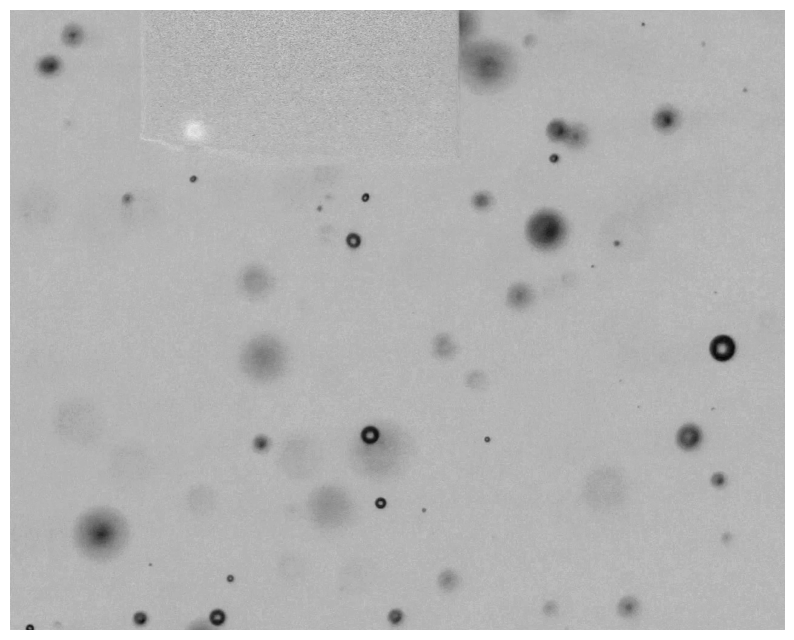

In [3]:
from google.colab import drive
drive.mount('/content/drive')

if using_colab:
    #image= Image.open("/content/drive/MyDrive/Master's Data Processing/Thesis Data/15 Degree/120F/0_2 Percent Trial 1/4_5/3 - Normalized/Frame_0201.png")
    image = Image.open("/content/drive/MyDrive/Master's Data Processing/Thesis Data/15 Degree/180F/0_2 Percent Trial 2/4_5/3 - Normalized/Frame_0051.png")

else:
    image = Image.open("../data/test_frames/Frame_0009.png")

image = np.array(image.convert("RGB"))

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


## Build SAM


In [4]:
import os
import subprocess
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# --- Choose model ---
model_choice = "small"  # "tiny", "small", "base_plus", "large"

# --- Colab vs local pathing ---
base_ckpt_path = "../checkpoints" if using_colab else "../../sam2/checkpoints"
cfg_dir = "configs/sam2.1"

# --- Model registry ---
sam2_models = {
    "tiny":       ("sam2.1_hiera_tiny.pt",      "sam2.1_hiera_t.yaml"),
    "small":      ("sam2.1_hiera_small.pt",     "sam2.1_hiera_s.yaml"),
    "base_plus":  ("sam2.1_hiera_base_plus.pt", "sam2.1_hiera_b.yaml"),
    "large":      ("sam2.1_hiera_large.pt",     "sam2.1_hiera_l.yaml")
}

sam2_urls = {
    "tiny":      "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt",
    "small":     "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt",
    "base_plus": "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt",
    "large":     "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt"
}

# --- Resolve paths ---
ckpt_file, cfg_file = sam2_models[model_choice]
ckpt_path = os.path.join(base_ckpt_path, ckpt_file)
cfg_path = os.path.join(cfg_dir, cfg_file)

# --- Download checkpoint if missing ---
if not os.path.exists(ckpt_path):
    print(f"[INFO] Checkpoint '{ckpt_file}' not found. Downloading from Meta URL...")
    url = sam2_urls[model_choice]
    # Use wget via subprocess for compatibility
    subprocess.run(["wget", "-P", base_ckpt_path, url], check=True)
else:
    print(f"[INFO] Checkpoint '{ckpt_file}' found.")

# --- Load model ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Loading SAM2 model: {model_choice}")
sam2 = build_sam2(cfg_path, ckpt_path, device=device, apply_postprocessing=False)


[INFO] Checkpoint 'sam2.1_hiera_small.pt' not found. Downloading from Meta URL...
[INFO] Loading SAM2 model: small


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:


In [5]:
mask_generator_3 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=90,
    points_per_batch=25, # Keep high for speed if memory allows, adjust if still OOM
    pred_iou_thresh=0.85, # Higher threshold for better quality and focus
    stability_score_thresh=0.85, # Higher threshold for better quality and focus
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=5,  # Set minimum area to 5 pixels
    use_m2m=True, # Disable M2M for speed
)


/usr/local/lib/python3.11/dist-packages/sam2/sam2_image_predictor.py:431: UserWarning: /usr/local/lib/python3.11/dist-packages/sam2/_C.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


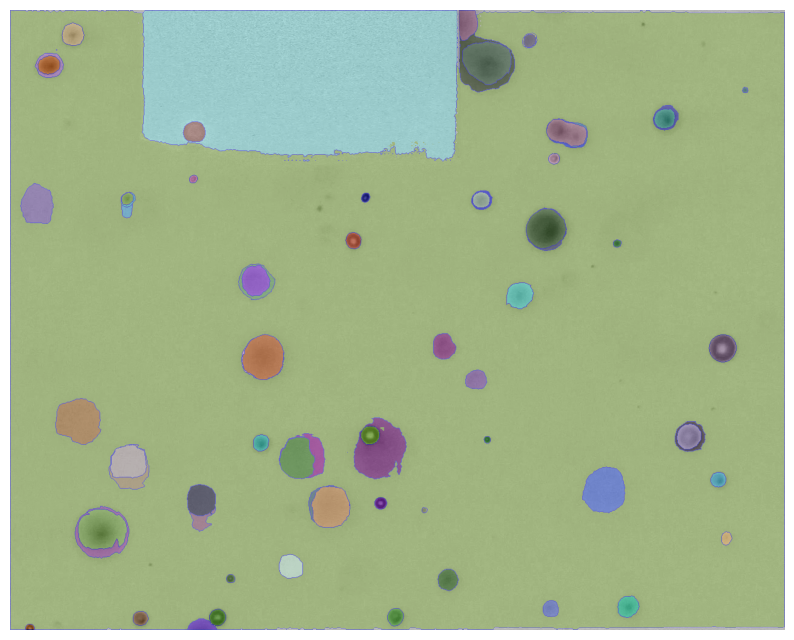

In [6]:
torch.cuda.empty_cache()
masks3 = mask_generator_3.generate(image);

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks3)
plt.axis('off')
plt.show()

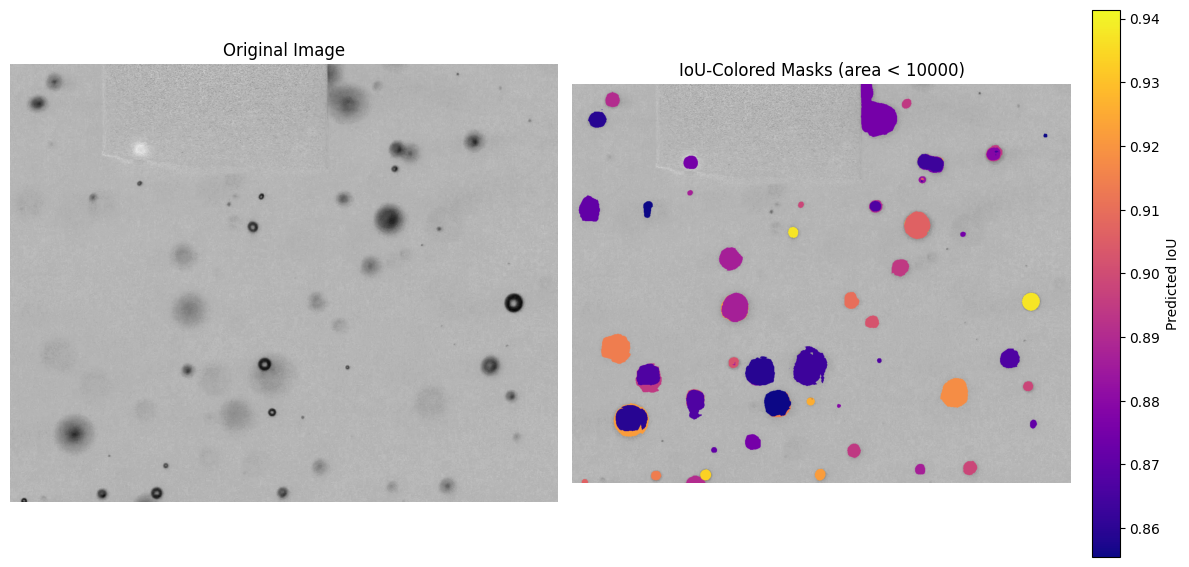

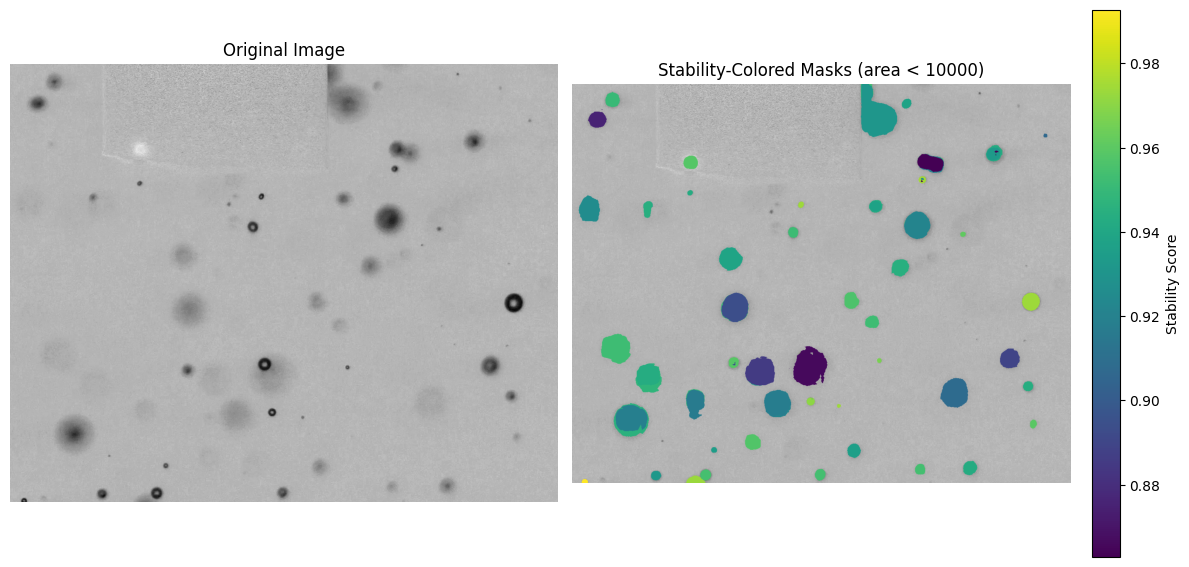

In [7]:
plot_iou_colormap_overlay(image, masks3, max_area = 10000)
plot_stability_colormap_overlay(image, masks3, max_area=10000)


In [8]:
# Assuming 'image' is a NumPy array (H, W, 3) and 'masks' is a list of SAM mask dicts:
import cv2
#interactive_filtered_masks_single(image, masks3)
interactive_filtered_masks_dual(image,masks3,700)

In [9]:
def interactive_sobel_focus_mask(image):
    """
    Create and visualize a focus mask using Sobel edge detection with adjustable sensitivity.

    Parameters:
        image: np.ndarray (RGB image)
    """

    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    # Convert to grayscale once
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sliders
    sobel_ksize_slider = widgets.IntSlider(value=3, min=1, max=9, step=2,
                                           description='Kernel Size', continuous_update=False)

    threshold_slider = widgets.IntSlider(value=100, min=0, max=255, step=1,
                                         description='Magnitude Thresh', continuous_update=False)

    out = widgets.Output()

    def update(change):
        with out:
            clear_output(wait=True)

            ksize = sobel_ksize_slider.value
            mag_thresh = threshold_slider.value

            # Apply Sobel filter
            sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
            sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
            sobel_mag = np.sqrt(sobel_x**2 + sobel_y**2)
            sobel_mag = (sobel_mag / sobel_mag.max() * 255).astype(np.uint8)

            # Plot
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Original")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(sobel_mag, cmap='gray')
            plt.title("Sobel Magnitude")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

    sobel_ksize_slider.observe(update, names='value')
    threshold_slider.observe(update, names='value')

    display(widgets.VBox([sobel_ksize_slider, threshold_slider, out]))
    update(None)
interactive_sobel_focus_mask(image)

In [10]:
def sobel_edge_focus_filter_viewer(image, masks):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # === Sliders ===
    ksize_slider = widgets.IntSlider(value=1, min=1, max=9, step=2, description="Sobel ksize")
    focus_thresh_slider = widgets.FloatSlider(value=50, min=10, max=150, step=5, description="Focus Threshold")
    max_diam_slider = widgets.IntSlider(value=300, min=0, max=5000, step=100, description="Max Diam (px)")

    out = widgets.Output()

    def update(change):
        with out:
            clear_output(wait=True)

            ksize = ksize_slider.value
            focus_thresh = focus_thresh_slider.value
            max_diam = max_diam_slider.value

            # --- 1. Sobel Magnitude ---
            sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
            sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
            sobel_mag = np.sqrt(sobel_x**2 + sobel_y**2)
            sobel_mag = (sobel_mag / sobel_mag.max() * 255).astype(np.uint8)

            # --- 2. Just raw Sobel magnitude (grayscale image) ---
            sobel_display = cv2.cvtColor(sobel_mag, cv2.COLOR_GRAY2RGB)

            # --- 3. Overlay all masks under max diameter ---
            overlay_all = image.copy()
            for m in masks:
                mask = m['segmentation'].astype(np.uint8)
                area = np.sum(mask)
                equiv_diam = 2 * np.sqrt(area / np.pi)
                if equiv_diam > max_diam:
                    continue
                color = np.random.randint(0, 255, size=(3,), dtype=np.uint8)
                for c in range(3):
                    overlay_all[..., c] = np.where(mask, color[c], overlay_all[..., c])

            # --- 4. Filtered masks using edge Sobel focus ---
            overlay_filtered = image.copy()
            kept = 0
            for m in masks:
                mask = m['segmentation'].astype(np.uint8)
                area = np.sum(mask)
                equiv_diam = 2 * np.sqrt(area / np.pi)
                if equiv_diam > max_diam:
                    continue

                edge_mask = cv2.dilate(mask, np.ones((3, 3), np.uint8)) - mask
                focus_score = np.mean(sobel_mag[edge_mask.astype(bool)])
                if focus_score >= focus_thresh:
                    kept += 1
                    color = np.array([255, 255, 0])  # yellow
                    for c in range(3):
                        overlay_filtered[..., c] = np.where(mask, color[c], overlay_filtered[..., c])

            # === Plot All Steps ===
            fig, axs = plt.subplots(1, 4, figsize=(18, 5))
            axs[0].imshow(image)
            axs[0].set_title("1. Raw Image")

            axs[1].imshow(sobel_mag, cmap="gray")
            axs[1].set_title("2. Sobel Magnitude")

            axs[2].imshow(overlay_all)
            axs[2].set_title(f"3. All Masks (D < {max_diam})")

            axs[3].imshow(overlay_filtered)
            axs[3].set_title(f"4. Focus-Filtered Masks\nKept: {kept}")

            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()

    # Register slider observers
    for slider in [ksize_slider, focus_thresh_slider, max_diam_slider]:
        slider.observe(update, names='value')

    display(widgets.VBox([
        widgets.HBox([ksize_slider, focus_thresh_slider, max_diam_slider]),
        out
    ]))
    update(None)

sobel_edge_focus_filter_viewer(image, masks3)